# Exploration of Retinal Cells with AngioTool

In [5]:
import numpy as np
import pandas as pd

unblinded_file = '../data/unblinded_data.csv'
df = pd.read_csv(unblinded_file)

df.head() # Look at first five rows "header"

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points,Litter,AnimalID,Genotype
0,65.034,119,14.215,16,35,35-3,+/+
1,61.498,183,16.877,17,35,35-3,+/+
2,55.247,157,15.501,29,35,35-3,+/+
3,55.219,138,14.466,37,35,35-5,DEE/DEE
4,51.731,134,13.181,32,35,35-5,DEE/DEE


### Average over Litter and Genotype

1. Pivot by `Genotype` and `Litter` using `set_index()`.

2. Make sure the genotype ordering is consistent for all litters by using `sort_index()`.

3. Calculate mean values within litters for each genotype

In [7]:
data_mean = (df
             .set_index(['Litter', 'Genotype']) # pivot
             .sort_index(level = ['Litter', 'Genotype'])
             .mean(level = ['Litter', 'Genotype'])
            )
data_mean

Vessels percentage area  Total Number of Junctions  \
Litter Genotype                                                       
35     +/+                     60.593000                 153.000000   
       DEE/DEE                 53.619000                 132.333333   
36     +/+                     64.298667                 171.666667   
       DEE/DEE                 62.152500                 136.833333   
37     +/+                     58.682000                 110.000000   
       DEE/+                   61.730500                 161.000000   
       DEE/DEE                 54.292000                  98.333333   
39     +/+                     56.754800                 163.400000   
       DEE/+                   55.086333                 119.666667   
       DEE/DEE                 50.380200                 118.400000   
40     +/+                     55.955667                 177.000000   
       DEE/+                   51.474500                 111.250000   
       DEE/DEE                 51.083200                 116.400000   
41     +/+                     49.744400                 106.200000   
       DEE/DEE                 49.865333                  91.333333   

                 Total Vessels Length  Total Number of End Points  
Litter Genotype                                                    
35     +/+                  15.531000                   20.666667  
       DEE/DEE              13.567333                   38.666667  
36     +/+                  16.085667                   26.333333  
       DEE/DEE              14.415500                   31.166667  
37     +/+                  13.102333                   25.333333  
       DEE/+                15.673000                   32.500000  
       DEE/DEE              12.666333                   27.666667  
39     +/+                  15.476600                   52.200000  
       DEE/+                13.478500                   36.500000  
       DEE/DEE              12.999400                   45.800000  
40     +/+                  16.085333                   46.833333  
       DEE/+                12.847500                   32.250000  
       DEE/DEE              13.234000                   34.200000  
41     +/+                  11.683800                   39.800000  
       DEE/DEE              11.324000                   40.666667

### Split data

`data_mean` is a `MultiIndex` object instead of your usual `DataFrame`

In [8]:
data_mean.index

MultiIndex(levels=[[35, 36, 37, 39, 40, 41], ['+/+', 'DEE/+', 'DEE/DEE']],
           labels=[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5], [0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2]],
           names=['Litter', 'Genotype'])

We will use `panda`'s cross-section function, `DataFrame.xs`, to separate our data by genotype.

| Wild type | Mutant  |
|-----------|---------|
| +/+       | DEE/DEE |

In [9]:
wild =   data_mean.xs('+/+',     level = 'Genotype')
mutant = data_mean.xs('DEE/DEE', level = 'Genotype')

In [10]:
## Get parameter data arrays
wildVPA =           wild['Vessels percentage area'].values
wildNJunctions =    wild['Total Number of Junctions'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints =    wild['Total Number of End Points'].values

mutantVPA =           mutant['Vessels percentage area'].values
mutantNJunctions =    mutant['Total Number of Junctions'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints =    mutant['Total Number of End Points'].values

In [11]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def pair_dot_plot(befores, afters, ylabel):
    
    # plotting the points
    plt.scatter(np.zeros(len(befores)), befores)
    plt.scatter(np.ones(len(afters)), afters)

    # plotting the lines
    for i in range(len(befores)):
        plt.plot( [0,1], [befores[i], afters[i]], c='k')

    plt.xticks([0,1], ['+/+', 'mutant'])
    plt.xlim([-0.5, 1.5])
    plt.ylabel(ylabel)

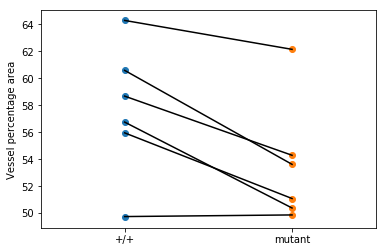

In [12]:
pair_dot_plot(wildVPA, mutantVPA, 'Vessel percentage area')

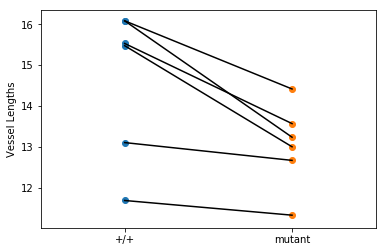

In [13]:
pair_dot_plot(wildVesselsLength, mutantVesselsLength, 'Vessel Lengths')

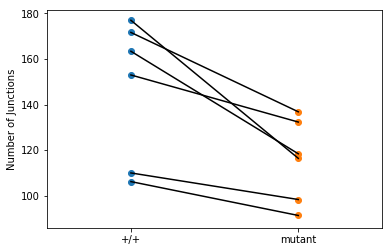

In [14]:
pair_dot_plot(wildNJunctions, mutantNJunctions, 'Number of Junctions')

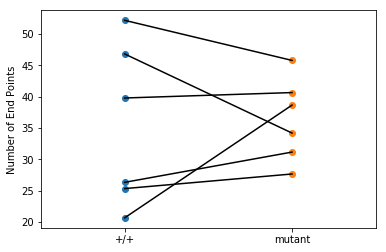

In [15]:
pair_dot_plot(wildNEndPoints, mutantNEndPoints, 'Number of End Points')

## Hypothesis testing

Now that we have our data ready to go, we can do a **paired t-test**.

`scipy` contains useful things for scientific analysis, and they have a built-in paired t-test function called `ttest_rel`.

In [16]:
from scipy import stats

## Do paired/dependent t-tests
t_VPA, p_VPA = stats.ttest_rel(wildVPA, mutantVPA)

t_n_junct, p_n_junct = stats.ttest_rel(
    wildNJunctions, mutantNJunctions)

t_vessel_length, p_vessel_length = stats.ttest_rel(
    wildVesselsLength, mutantVesselsLength)

t_n_endpoints, p_n_endpoints = stats.ttest_rel(
    wildNEndPoints, mutantNEndPoints)

t_statistics = [t_VPA, t_n_junct, t_vessel_length, t_n_endpoints]
p_values =     [p_VPA, p_n_junct, p_vessel_length, p_n_endpoints]

stat_df = pd.DataFrame({'Parameter': wild.columns,
                        't_statistic': t_statistics, 
                        'p_value': p_values})

stat_df.set_index('Parameter')

,p_value,t_statistic
Parameter,,
Vessels percentage area,0.013137,3.761482
Total Number of Junctions,0.010252,4.007010
Total Vessels Length,0.012036,3.847175
Total Number of End Points,0.795419,-0.273483


It appears that our p-values for 
- `Vessels percentage area` 
- `Total Number of Junctions`
- `Total Vessels Length`

are statistically significant at the p < 0.05 level.

However, p-values by themselves aren't very useful. Sure, there's indication of a statistically significant result, but what sort of a difference does it make?

To answer this, we can look at **effect size**.

"Cohen's d" is frequently seen among literature, but there are a handful of techniques that are mistakenly attributed to be Cohen's d. For a good review, I recommend https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/.

In this analysis, we will use Cohen's $d_z$, where the $z$ reminds us that we are looking at the difference of two samples ($x$ and $y$).



In [17]:
## Calculate Cohen's d using test statistic and n
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/
def get_cohens_d_z(t_statistic, n):
    """Returns Cohen's d_z
    
    One way of calculating Cohen's d is by 
    taking the t-statistic and dividing it by
    the square root of the sample size.
    """
    d = [t / np.sqrt(n)
         for t in t_statistic]
    
    return d

n = len(wildVPA)
cohens_d_values = get_cohens_d_z(t_statistics, n)

pd.options.display.float_format = '{:,.3f}'.format

stat_df['cohen_dz'] = cohens_d_values
stat_df.set_index('Parameter')

,p_value,t_statistic,cohen_dz
Parameter,,,
Vessels percentage area,0.013,3.761,1.536
Total Number of Junctions,0.010,4.007,1.636
Total Vessels Length,0.012,3.847,1.571
Total Number of End Points,0.795,-0.273,-0.112


## Effect size results
The Cohen d$_z$ values indicate that our effect sizes are on the order of 1.5$\sigma$.

There's some concern that Cohen's d is biased upwards for small samples (n < 20)

For fun, we can calculate cohen's $d$ using means and stds. We expect calculating the effect size from the t-statistic to yield identical results.

In [18]:
pd.options.display.float_format = '{:,.2f}'.format

## Look at the difference in means
diff = wild - mutant
diff

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
Litter,,,,
35,6.97,20.67,1.96,-18.00
36,2.15,34.83,1.67,-4.83
37,4.39,11.67,0.44,-2.33
39,6.37,45.00,2.48,6.40
40,4.87,60.60,2.85,12.63
41,-0.12,14.87,0.36,-0.87


In [19]:
means = diff.mean()
means

Vessels percentage area       4.11
Total Number of Junctions    31.27
Total Vessels Length          1.63
Total Number of End Points   -1.17
dtype: float64

In [20]:
stds = diff.std()
stds

Vessels percentage area       2.67
Total Number of Junctions    19.12
Total Vessels Length          1.04
Total Number of End Points   10.45
dtype: float64

In [21]:
means/stds

Vessels percentage area       1.54
Total Number of Junctions     1.64
Total Vessels Length          1.57
Total Number of End Points   -0.11
dtype: float64

In [24]:
#fig, axes = plt.subplot(2,2, figsize=(10,10))
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#fig, axes = plt.subplots(figsize=(5,5))


#diff.reset_index()
#diff['Vessels percentage area']
#diff.T.index

#diff

#sns.barplot(diff['Vessels percentage area'],
#           #estimator=np.mean, 
#            ci='sd',
#            orient='v')

#plt.title('Difference between wild type and mutant')

#sns.barplot(merged_inner, estimator=np.mean)

#plt.title('Difference between wild type and mutant')

In [25]:
data_mean = data_mean.reset_index(0).reset_index()

#data_mean.index

data_mean

,level_0,index,Genotype,Litter,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
0,0,0,+/+,35,60.59,153.00,15.53,20.67
1,1,1,DEE/DEE,35,53.62,132.33,13.57,38.67
2,2,2,+/+,36,64.30,171.67,16.09,26.33
3,3,3,DEE/DEE,36,62.15,136.83,14.42,31.17
4,4,4,+/+,37,58.68,110.00,13.10,25.33
5,5,5,DEE/+,37,61.73,161.00,15.67,32.50
6,6,6,DEE/DEE,37,54.29,98.33,12.67,27.67
7,7,7,+/+,39,56.75,163.40,15.48,52.20
8,8,8,DEE/+,39,55.09,119.67,13.48,36.50
9,9,9,DEE/DEE,39,50.38,118.40,13.00,45.80


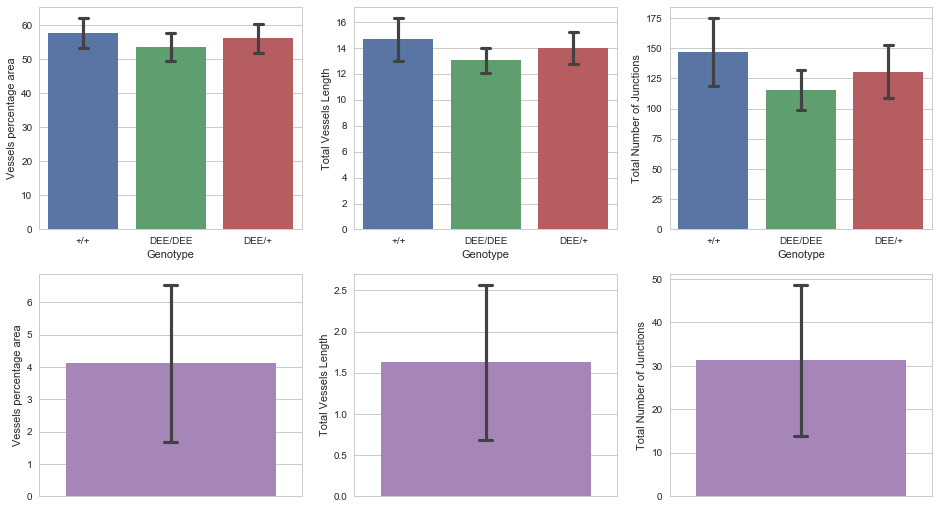

In [26]:
## This is what you would do for an independent t-test
## But we did a dependent t-test
## IMO this should not be shown since it is highly misleading

fig, axes = plt.subplots(nrows= 2, ncols=3, figsize = (16,9))
ax = axes.ravel()

parameters = ['Vessels percentage area', 'Total Vessels Length',
             'Total Number of Junctions']

with sns.plotting_context("notebook", font_scale=1.5):
    for i, parameter in enumerate(parameters): 
        g = sns.factorplot(x = 'Genotype',
                           y = parameter ,
                           #hue_order = ['+/+', 'DEE/DEE'],
                           ci = 'sd',
                           kind = 'bar',
                           capsize = .1,
                           data = data_mean,
                           ax = ax[i]
                          )
        
        _ = sns.barplot(diff[parameter],
                        ci = 'sd',
                        orient ='v',
                        capsize = .05,
                        ax = ax[i+3],
                        color = sns.xkcd_rgb["wisteria"],
                        #alpha=0.9
                       )
        ### factorplot creates its own figure
        ### But we can tell it to plot to a figure
        ### as created outside this loop.
        ### 
        ### If plt.close(g.fig) isn't called,
        ### there will be blank figures.
        plt.close(g.fig)


In [29]:
#sns.factorplot(x = "Litter", y="Vessels percentage area",
#               col = 'Genotype', data=merged_inner)

## Mean and std for different variables in different litters

If you want to look at the numbers after averaging, here they are.

In [50]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe()
)

count  mean   std   min   25%   50%   75%   max
Litter Genotype                                                 
35     +/+        3.00 20.67  7.23 16.00 16.50 17.00 23.00 29.00
       DEE/DEE    3.00 38.67  7.64 32.00 34.50 37.00 42.00 47.00
36     +/+        3.00 26.33  3.51 23.00 24.50 26.00 28.00 30.00
       DEE/DEE    6.00 31.17  5.71 27.00 27.25 28.00 35.50 39.00
37     +/+        3.00 25.33  9.81 14.00 22.50 31.00 31.00 31.00
       DEE/+      2.00 32.50 12.02 24.00 28.25 32.50 36.75 41.00
       DEE/DEE    3.00 27.67  8.14 22.00 23.00 24.00 30.50 37.00
39     +/+        5.00 52.20  6.65 44.00 49.00 50.00 58.00 60.00
       DEE/+      6.00 36.50  9.22 26.00 33.00 33.50 38.50 53.00
       DEE/DEE    5.00 45.80  3.70 42.00 43.00 45.00 48.00 51.00
40     +/+        6.00 46.83  6.01 36.00 45.50 48.00 50.50 53.00
       DEE/+      4.00 32.25  6.08 25.00 28.75 32.50 36.00 39.00
       DEE/DEE    5.00 34.20  5.07 29.00 30.00 33.00 39.00 40.00
41     +/+        5.00 39.80  8.50 30.00 32.00 43.00 44.00 50.00
       DEE/DEE    3.00 40.67  6.81 33.00 38.00 43.00 44.50 46.00

In [51]:
(df.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 60.59 4.96 55.25 58.37 61.50 63.27 65.03
       DEE/DEE    3.00 53.62 1.76 51.73 52.82 53.91 54.56 55.22
36     +/+        3.00 64.30 2.31 62.81 62.97 63.13 65.04 66.96
       DEE/DEE    6.00 62.15 1.86 60.14 60.84 61.98 62.81 65.27
37     +/+        3.00 58.68 2.96 55.29 57.66 60.02 60.38 60.73
       DEE/+      2.00 61.73 5.38 57.92 59.83 61.73 63.63 65.54
       DEE/DEE    3.00 54.29 7.47 48.76 50.04 51.32 57.06 62.79
39     +/+        5.00 56.75 1.71 54.59 55.50 56.94 58.18 58.57
       DEE/+      6.00 55.09 2.05 52.11 54.29 54.79 56.14 58.11
       DEE/DEE    5.00 50.38 5.23 43.96 48.31 50.51 50.76 58.36
40     +/+        6.00 55.96 3.04 52.12 53.63 56.27 57.76 60.07
       DEE/+      4.00 51.47 3.82 46.53 49.46 52.22 54.23 54.94
       DEE/DEE    5.00 51.08 2.04 47.50 51.34 52.04 52.19 52.35
41     +/+        5.00 49.74 4.64 43.90 48.30 49.42 50.33 56.77
       DEE/DEE    3.00 49.87 1.52 48.60 49.02 49.45 50.50 51.55

In [52]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Number of Junctions']
                     .describe()
)

count   mean   std    min    25%    50%    75%    max
Litter Genotype                                                       
35     +/+        3.00 153.00 32.19 119.00 138.00 157.00 170.00 183.00
       DEE/DEE    3.00 132.33  6.66 125.00 129.50 134.00 136.00 138.00
36     +/+        3.00 171.67 29.54 143.00 156.50 170.00 186.00 202.00
       DEE/DEE    6.00 136.83 30.67  87.00 121.75 148.00 154.00 169.00
37     +/+        3.00 110.00 19.29  96.00  99.00 102.00 117.00 132.00
       DEE/+      2.00 161.00  2.83 159.00 160.00 161.00 162.00 163.00
       DEE/DEE    3.00  98.33 31.79  73.00  80.50  88.00 111.00 134.00
39     +/+        5.00 163.40 17.66 132.00 169.00 170.00 172.00 174.00
       DEE/+      6.00 119.67 11.99 107.00 111.25 118.50 123.50 140.00
       DEE/DEE    5.00 118.40 26.62  96.00 104.00 112.00 116.00 164.00
40     +/+        6.00 177.00 21.49 147.00 160.50 184.00 193.25 198.00
       DEE/+      4.00 111.25 14.93 101.00 101.75 105.50 115.00 133.00
       DEE/DEE    5.00 116.40 23.07  94.00 102.00 107.00 128.00 151.00
41     +/+        5.00 106.20 31.03  68.00  87.00 107.00 120.00 149.00
       DEE/DEE    3.00  91.33 25.58  62.00  82.50 103.00 106.00 109.00

In [53]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 15.53 1.33 14.21 14.86 15.50 16.19 16.88
       DEE/DEE    3.00 13.57 0.78 13.05 13.12 13.18 13.82 14.47
36     +/+        3.00 16.09 1.44 14.64 15.37 16.09 16.81 17.52
       DEE/DEE    6.00 14.42 1.71 11.54 13.64 15.17 15.40 16.01
37     +/+        3.00 13.10 1.05 12.26 12.52 12.77 13.52 14.28
       DEE/+      2.00 15.67 0.02 15.66 15.67 15.67 15.68 15.69
       DEE/DEE    3.00 12.67 1.74 11.29 11.69 12.08 13.35 14.62
39     +/+        5.00 15.48 0.85 14.00 15.68 15.68 15.88 16.14
       DEE/+      6.00 13.48 0.90 12.36 13.01 13.52 13.59 15.02
       DEE/DEE    5.00 13.00 1.59 11.27 12.61 12.66 12.84 15.62
40     +/+        6.00 16.09 0.98 14.88 15.20 16.46 16.86 16.95
       DEE/+      4.00 12.85 1.03 11.96 12.10 12.61 13.36 14.21
       DEE/DEE    5.00 13.23 1.09 11.99 12.70 12.79 14.01 14.69
41     +/+        5.00 11.68 2.02  9.64 10.55 10.94 12.50 14.79
       DEE/DEE    3.00 11.32 1.96  9.08 10.63 12.18 12.45 12.71

In [45]:
# Potentially useful snippets for the future

In [46]:
# Remove heterozygous data
# We are comparing wild type and mutant.
# To make things easier later, let's now remove 
# the heterozygous data using string matching with regular expressions.

# + is a special character. must prepend with \
#het_regex = "DEE/\+" 

#merged_inner = merged_inner[~merged_inner['Genotype']
#                            .str.match(het_regex)]

In [54]:
#
#def get_unbiased_d(cohens_d, n):
#    """Returns an unbiased estimator of effect size
#    
#    Cohen's d is biased upwards for small sample size.
#    Hedges and Olkin (1985) suggested a correction to
#    Cohen's d.
#    """
#    d_unbiased = [d * (1 - 3/(4*(n - 2) - 1))
#                 for d in cohens_d]
#    
#    return d_unbiased

#def other_d(t_statistic, n):
#    other_d = [2*t / np.sqrt(n-2)
#              for t in t_statistic]
    
#    return other_d

#def another_d(t_statistic, n):
#    another_d = [np.sqrt(2) * t / np.sqrt(n-1)
#                for t in t_statistic]
    
#    return another_d

#print(other_d(t_statistics, n))


#unbiashed_d_values = get_unbiased_d(cohens_d_values, n)
#other_d_values = other_d(t_statistics, n)
#another_d_values = another_d(t_statistics, n)

#rounded_cohens = list(map(lambda x: np.round(x,1), cohens_d_values))
#print('cohens d:')
#print(cohens_d_values)
#print(["{:f}".format([print(d) for d in cohens_d_values])])
#print('unbiased d:')
#print(unbiashed_d_values)
#print('other d:')
#print(other_d_values)
#print('another d:')
#print(another_d_values)

In [55]:
##from scipy import stats
#import statsmodels.api as sm

#wild_data = [wildVPA, wildNJunctions, wildVesselsLength]
#mutant_data = [mutantVPA, mutantNJunctions, mutantVesselsLength]
#
#plt.close()
#fig, axes = plt.subplots(2, 3, figsize=(10,10),sharex=True)
#ax = axes.ravel()
#for i, (wild_var, mutant_var) in enumerate(
#    list(zip(wild_data, mutant_data))):
    
#    sm.graphics.qqplot(data=wild_var, ax=ax[i])
#    sm.graphics.qqplot(data=mutant_var, ax=ax[i+3])
#stats.probplot(wildVPA, plot=ax[0])
#plt.show()